In [4]:
import argparse 
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import torchvision.transforms as transforms
from torchvision import datasets
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
batch_size = 128                               
img_size = 28                                  
n_channels = 1                                    
n_classes = 10                                     
latent_dim = 100                                  
lr = 0.0002                                          

cuda = True if torch.cuda.is_available() else False
device = 'cuda:0' if cuda else 'cpu'

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# label and plot

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


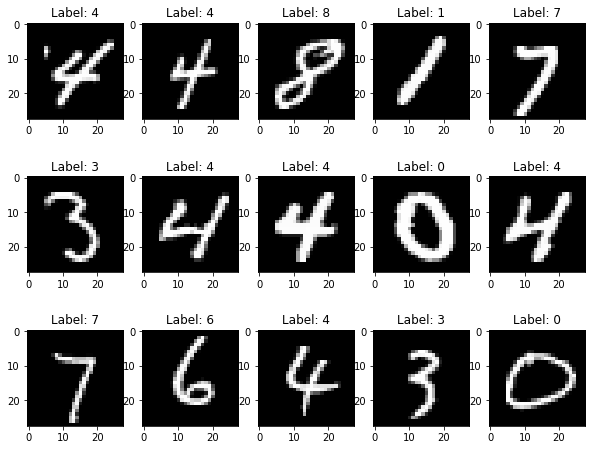

In [6]:
transform = transforms.Compose([
  transforms.ToTensor(),                           
  transforms.Normalize(mean=(0.5,), std=(0.5,))   
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)


fig,axes = plt.subplots(3,5,figsize=(10,8))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(15):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()


# function

In [7]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat,normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, momentum=0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128,normalize=True),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(n_channels*img_size*img_size)),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z):
        img = self.model(z.view(z.size(0),-1))
        img = img.view(img.size(0), n_channels,img_size,img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(n_channels*img_size*img_size), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, img):
        out = self.model(img.view(img.size(0), -1))
        out = out.view(-1)
        return out

def train_discriminator(discriminator, generator, images):
    d_optimizer.zero_grad()                                                     
    
    real_images = images.to(device)                                              
    real_labels_output = torch.ones(images.size(0)).to(device)                  

    real_validity = discriminator(real_images)                                   
    real_loss = criterion(real_validity, real_labels_output)                  

    z = torch.randn(images.size(0), latent_dim).to(device)                      
    fake_images = generator(z)                                               
    fake_labels_output =  torch.zeros(images.size(0)).to(device)                 

    fake_validity = discriminator(fake_images)                                   
    fake_loss =  criterion(fake_validity, fake_labels_output)                  

    d_loss = real_loss + fake_loss                                              
    d_loss.backward()                                                           
    d_optimizer.step()                                                          

    return d_loss.item()

def train_generator(generator, discriminator, batch_size):
    g_optimizer.zero_grad()                                                      
    
    real_labels_output = torch.ones(batch_size).to(device)            
    z = torch.randn(batch_size, latent_dim).to(device)                          
    fake_images = generator(z)                                                   
    

    fake_validity = discriminator(fake_images)                                 
    g_loss = criterion(fake_validity, real_labels_output)                  

    g_loss.backward()                                                            
    g_optimizer.step()                                                           

    return g_loss.item()

def test_plot(num_test_samples,plot_axis,generator,latent_dim):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).to(device)
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise)

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()

In [8]:
criterion = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

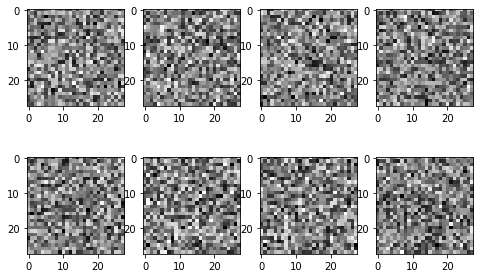

In [10]:
test_plot(num_test_samples=8,plot_axis=(4,2),generator=generator,latent_dim=latent_dim)

In [11]:
D_losses = []
G_losses = []

n_epochs = 500                                                                 

for epoch in tqdm(range(n_epochs)):
    d_avg_loss = 0
    g_avg_loss = 0

    for n, (images, _) in enumerate(train_loader):
        d_loss = train_discriminator(discriminator, generator, images)          
        g_loss = train_generator(generator, discriminator, batch_size)        
        d_avg_loss += d_loss
        g_avg_loss += g_loss

    d_avg_loss /= len(train_loader)
    g_avg_loss /= len(train_loader)
    D_losses.append(d_avg_loss)
    G_losses.append(g_avg_loss)

    if epoch % 100 == 0 :
      print('Epoch : [{}] d_loss : {:4f} g_loss : {:4f}'.format(epoch, d_avg_loss, g_avg_loss))

  0%|          | 1/500 [00:13<1:52:03, 13.47s/it]

Epoch : [0] d_loss : 0.464276 g_loss : 4.638186


 20%|██        | 101/500 [22:46<1:29:11, 13.41s/it]

Epoch : [100] d_loss : 0.506138 g_loss : 2.846703


 40%|████      | 201/500 [45:19<1:06:59, 13.44s/it]

Epoch : [200] d_loss : 0.649283 g_loss : 2.332745


 60%|██████    | 301/500 [1:07:55<44:25, 13.39s/it]

Epoch : [300] d_loss : 0.703813 g_loss : 2.027065


 80%|████████  | 401/500 [1:30:28<22:15, 13.49s/it]

Epoch : [400] d_loss : 0.738400 g_loss : 1.829136


100%|██████████| 500/500 [1:52:55<00:00, 13.55s/it]


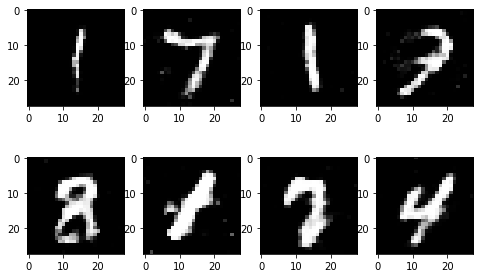

In [12]:
test_plot(num_test_samples=8,plot_axis=(4,2),generator=generator,latent_dim=latent_dim)